In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn


import torch.quantization as tq

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                  padding=0, bias=False)
    )


class ShuffleUpBlock(nn.Module):
    def __init__(self, scale=2, add_blur=False):
        super(UpBlock, self).__init__()

        self.shuffle = nn.PixelShuffle(scale)
        self.has_blur = add_blur
        if self.has_blur:
            self.blur = nn.AvgPool2d(2, 1)

    def forward(self, x):
        if self.has_blur:
            x = self.blur(x)
        x = self.shuffle(x)
        return x


class Self_Attn(nn.Module):
    """ Self attention Layer"""

    def __init__(self, in_dim, activation):
        super(Self_Attn, self).__init__()
        self.chanel_in = in_dim
        self.activation = activation

        self.f_functional = torch.nn.quantized.FloatFunctional()

        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(
            m_batchsize, -1, width*height).permute(0, 2, 1)  # B X CX(N)
        proj_key = self.key_conv(x).view(
            m_batchsize, -1, width*height)  # B X C x (*W*H)
        energy = torch.bmm(proj_query, proj_key)  # transpose check
        attention = self.softmax(energy)  # BX (N) X (N)
        proj_value = self.value_conv(x).view(
            m_batchsize, -1, width*height)  # B X C X N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.f_functional.add(self.gamma*out, x)
        return out, attention


class UpBlock(nn.Module):
    def __init__(self, in_f, out_f, stride=2, add_blur=False):
        super(UpBlock, self).__init__()

        self.shuffle = nn.ConvTranspose2d(
            in_f, out_f, kernel_size=3, stride=stride, padding=0)
        self.has_blur = add_blur
        if self.has_blur:
            self.blur = nn.AvgPool2d(2, 1)

    def forward(self, x):
        x = self.shuffle(x)
        if self.has_blur:
            x = self.blur(x)
        return x


def add_resblocks(channel_num, nr_blocks):
    return nn.Sequential(*[ResBlock(channel_num) for i in range(nr_blocks)])


class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()

        self.f_functional = torch.nn.quantized.FloatFunctional()
        
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num),
            nn.ReLU(inplace=True),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.block(x)
        #out += residual
        out = self.f_functional.add(out, residual)
        out = self.relu(out)
        return out

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.quant = tq.QuantStub()
        self.dequant = tq.DeQuantStub()

        self.down = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1,
                      padding=7//2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            conv3x3(64, 128, stride=2),
            conv3x3(128, 128, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            conv3x3(128, 256, stride=2),
            conv3x3(256, 256, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.res = nn.Sequential(add_resblocks(256, 8))

        self.up = nn.Sequential(
            UpBlock(256, 128, stride=2, add_blur=True),
            conv3x3(128, 128, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            UpBlock(128, 64, stride=2, add_blur=True),
            conv3x3(64, 64, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=7//2)
        )

    def forward(self, x):
        x = self.quant(x)  
        x = self.down(x)

        x = self.res(x)
        x = self.up(x)
        x = self.dequant(x)
        return x

In [6]:
netG = Generator()
netG.eval()
pretrained_dir = r'/kaggle/input/weights/pytorch/default/1/trained_netG.pth'
netG.load_state_dict(torch.load(pretrained_dir, map_location=torch.device('cpu')))
None

In [52]:
import requests
from PIL import Image
from io import BytesIO

url = "https://picsum.photos/505"
img_bytes = requests.get(url).content
img = Image.open(BytesIO(img_bytes))


In [53]:
import torchvision.transforms as transforms

def get_no_aug_transform(size=512):
    return transforms.Compose([
        transforms.Resize(size=size),
        # transforms.CenterCrop(size=size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

trf = get_no_aug_transform()

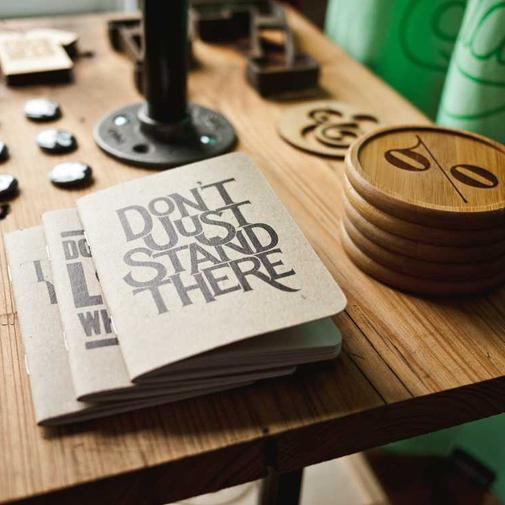

In [54]:
img

In [10]:
%%timeit

with torch.no_grad():
    x_generated = netG(
        trf(img).unsqueeze(0)
    )

5.03 s ± 86.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
with torch.no_grad():
    x_generated = netG(
        trf(img).unsqueeze(0)
    )

In [56]:
def inv_normalize(img, device='cpu'):
    # Adding 0.1 to all normalization values since the model is trained (erroneously) without correct de-normalization
    mean = torch.Tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.Tensor([0.229, 0.224, 0.225]).to(device)

    img = img * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)
    img = img.clamp(0, 1)
    return img

(-0.5, 511.5, 511.5, -0.5)

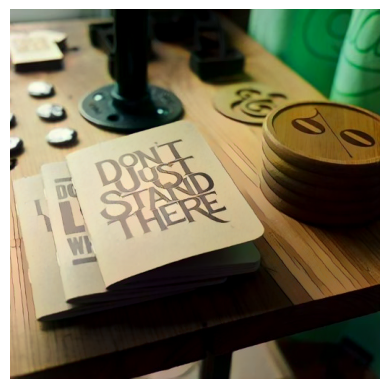

In [57]:
x_gen = x_generated
x_gen = inv_normalize(x_gen)
img_gen = x_gen.numpy()[0].transpose(1, 2, 0)
plt.imshow(img_gen)
plt.axis("off")

In [58]:
qconfig = tq.get_default_qconfig('qnnpack')

In [59]:
netG.qconfig = qconfig

In [60]:
from torchvision import datasets


calib_dataset = datasets.FakeData(
    size=16,
    transform=trf
)

calib_loader = torch.utils.data.DataLoader(calib_dataset, batch_size=4)

In [61]:
tq.prepare(netG, inplace=True)
None

In [62]:
from tqdm import tqdm


with torch.no_grad():
    for images, _ in tqdm(calib_loader):
        netG(images)

100%|██████████| 4/4 [01:55<00:00, 28.80s/it]


In [63]:
tq.convert(netG, inplace=True)


Generator(
  (quant): Quantize(scale=tensor([0.0179]), zero_point=tensor([114]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (down): Sequential(
    (0): QuantizedConv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), scale=0.04119286686182022, zero_point=127, padding=(3, 3), bias=False)
    (1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=0.12324701994657516, zero_point=128, bias=False)
    )
    (4): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.7722445726394653, zero_point=137, bias=False)
    )
    (5): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1):

In [64]:
%%timeit
with torch.no_grad():
    x_gen = netG(
        trf(img).unsqueeze(0)
    )

3.12 s ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
with torch.no_grad():
    x_gen = netG(
        trf(img).unsqueeze(0)
    )

(-0.5, 511.5, 511.5, -0.5)

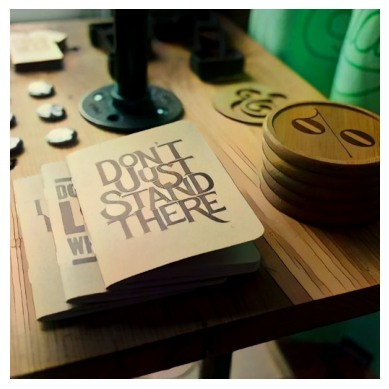

In [66]:
x_gen = inv_normalize(x_gen)
img_gen = x_gen.numpy()[0].transpose(1, 2, 0)
plt.imshow(img_gen)
plt.axis("off")